In [1]:
import glob
import pandas as pd
import re
import numpy as np
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from utils import fill_gaps
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

# What does this notebook do?

- The first part of the notebook provides the functions to pool multiple pairwise distance datasets from the same condition. 

- The second part, we apply some filters to the tracks to keep only good part of tracks



# Pooling datasets

In [2]:
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/hybrid_w1_original_w2_twocolormodel/"

# list_dir = ["time_acquisition/20211015_two_colour_degron_1s_2d/"]
# outname = "two_colors_distance_2d_1s.csv"

list_dir = [
    "30s_movies/20211120_two_colour_degron_30s/",
    "30s_movies/20211122_two_colour_degron_30s/",
    "30s_movies/20211123_two_colour_degron_30s/",
    "30s_movies/20211125_two_colour_degron_30s/",
    "30s_movies/20211126_two_colour_degron_30s/",
    "30s_movies/20211127_two_colour_degron_30s/",
    "30s_movies/20211128_two_colour_degron_30s/",
    "30s_movies/20211129_two_colour_degron_30s/",
    "30s_movies/20211130_two_colour_degron_30s/",
    "30s_movies/20211201_two_colour_degron_30s/",
    "30s_movies/20211202_two_colour_degron_30s/",
    "30s_movies/20211214_two_colour_degron_30s/",
    "30s_movies/20211215_two_colour_degron_30s/",
    "30s_movies/20211216_two_colour_degron_30s/",
    "30s_movies/20211218_two_colour_degron_30s/",
    "30s_movies/20211219_two_colour_degron_30s/",
]
outname = "two_colors_distance_30s.csv"

# list_dir = [
#     "20210921_two_colour_degron/",
#     "20210923_two_colour_degron/",
#     "20210927_two_colour_degron/",
#     "20210930_two_colour_degron/",
#     "20211118_two_colour_degron_10s/",
#     "20211119_two_colour_degron_10s/",
#     "20211121_two_colour_degron_10s/",
#     "20211122_two_colour_degron_10s/",
#     "20211125_two_colour_degron_10s/",
#     "20211126_two_colour_degron_10s/",
#     "20211127_two_colour_degron_10s/",
#     "20211130_two_colour_degron_10s/",
#     "20211202_two_colour_degron_10s/",
#     "20211203_two_colour_degron_10s/",
# ]
# outname = "two_colors_distance_10s.csv"

# list_dir = ["small_fluctuation_analysis/"]
# outname = "pairwise_twocolor_control.csv"

# list_dir = ["time_acquisition/20211117_two_colour_degron_60s/"]
# outname = "two_colors_distance_60s.csv"


list_dir = [f"{basedir}/{x}" for x in list_dir]

list_files = []

for directory in list_dir:
    list_files.append(glob.glob(f"{directory}/tracks_pairwise_with_cellid/*csv"))

list_files = [x for sub in list_files for x in sub]

pdf = PdfPages(f"{basedir}/{outname}.pdf")

In [3]:
df = pd.DataFrame()

for file in list_files:
    tmp = pd.read_csv(file)
    df = pd.concat([df, tmp])

df[["date", "cell_line", "induction_time", "rep", "motion_correction_type"]] = df[
    "filename"
].str.extract(
    r"(20[0-9]*)_[\w\W_]*?([^_]*)_([^_]*)_[\d]*?[perc_]*?([0-9])_[\w\W]*?_([\w]*)\.csv",
    expand=True,
)

today = datetime.datetime.now().strftime("%y%m%d")

df["condition"] = [
    f"{cl}_{time}" for cl, time in zip(df["cell_line"], df["induction_time"])
]

In [4]:
ntracks = df["uniqueid"].nunique()
av_length = np.mean(df["uniqueid"].value_counts().values)
av_distance = np.mean(df["distance"].values)
print(f"ntracks: {ntracks}")
print(f"av_length: {av_length}")
print(f"av_distance: {av_distance}")

ntracks: 2225
av_length: 134.61123595505617
av_distance: 0.32965007365750293


# Apply filters to tracks 

In [5]:
min_trackpoints = 25


def filter_data(df: pd.DataFrame, min_points: int):
    """Filter tracks with lower number of points"""
    df_filtered = pd.DataFrame()
    for _, sub in df.groupby("uniqueid"):
        if len(sub) > min_points:
            df_filtered = pd.concat([df_filtered, sub])
    return df_filtered


# Filter noisy 3D data points
distance = np.sqrt(np.sum(np.square(df[["x", "y"]].values), axis=1))
distance = np.log2(df["distance"] / distance)
threshold = np.quantile(distance, 0.95)
df = df[distance < threshold]

df = filter_data(df, min_trackpoints)

In [6]:
df = df.drop_duplicates()
df["distance"] = np.sqrt(np.sum(np.square(df[["x", "y", "z"]].values), axis=1))
ntracks = df["uniqueid"].nunique()
av_length = np.mean(df["uniqueid"].value_counts().values)
av_distance = np.mean(df["distance"].values)
print(f"ntracks: {ntracks}")
print(f"av_length: {av_length}")
print(f"av_distance: {av_distance}")

ntracks: 2159
av_length: 131.0722556739231
av_distance: 0.3230248541277593


Number of unique tracks per condition


/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


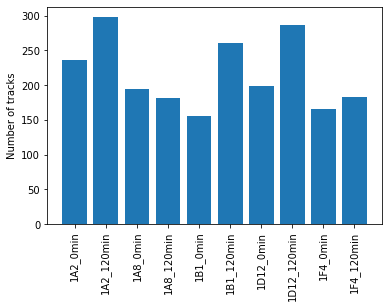

In [7]:
print("Number of unique tracks per condition")
a = pd.DataFrame(df.groupby('condition')['uniqueid'].nunique())
fig, ax = plt.subplots(1,1)
ax.bar(a.index, a['uniqueid'].values)
ax.set_xticklabels(a.index, rotation=90)
plt.ylabel("Number of tracks")

pdf.savefig(fig, bbox_inches = 'tight')

Average distance per line


/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


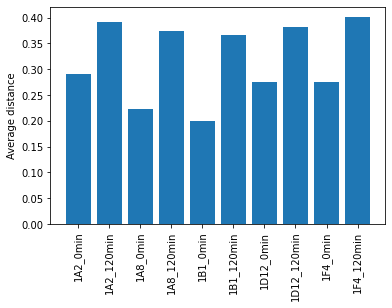

In [8]:
print("Average distance per line")
a = pd.DataFrame(df.groupby('condition')['distance'].mean())
fig, ax = plt.subplots(1,1)
ax.bar(a.index, a['distance'].values)
ax.set_xticklabels(a.index, rotation=90)
plt.ylabel("Average distance")

pdf.savefig(fig, bbox_inches = 'tight')

In [9]:
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/"
df.drop_duplicates().to_csv(f"{basedir}/{today}_{outname}.zip", index=False, compression="zip")
pdf.close()

In [10]:
def myread(file):
    data = pd.read_csv(file)
    data["z"] = data[["date", "z"]].groupby("date").apply(lambda x: x-np.mean(x))["z"]
    data["x"] = data[["date", "x"]].groupby("date").apply(lambda x: x-np.mean(x))["x"]
    data["y"] = data[["date", "y"]].groupby("date").apply(lambda x: x-np.mean(x))["y"]
    data["distance"] = np.sqrt(np.sum(np.square(data[["x", "y", "z"]].values), axis=1))
    return data


data = myread(f"{basedir}/211129_two_colors_distance_30s.csv.zip")
data.to_csv(f"{basedir}/220630_{outname}.zip", index=False, compression="zip")

In [5]:
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/"
def myread(file):
    data = pd.read_csv(file)
    data["z"] = data[["date", "z"]].groupby("date").apply(lambda x: x-np.mean(x))["z"]
    data["x"] = data[["date", "x"]].groupby("date").apply(lambda x: x-np.mean(x))["x"]
    data["y"] = data[["date", "y"]].groupby("date").apply(lambda x: x-np.mean(x))["y"]
    data["distance"] = np.sqrt(np.sum(np.square(data[["x", "y", "z"]].values), axis=1))
    return data


data = myread(f"{basedir}/211129_two_colors_distance_30s.csv.zip")
data_uncorr = pd.read_csv(f"{basedir}/211129_two_colors_distance_30s.csv.zip")

In [6]:
data.groupby('condition')['distance'].mean()

condition
1A2_0min       0.278819
1A2_120min     0.386994
1A8_0min       0.216885
1A8_120min     0.369950
1B1_0min       0.195393
1B1_120min     0.357297
1D12_0min      0.270042
1D12_120min    0.377239
1F4_0min       0.270099
1F4_120min     0.399319
Name: distance, dtype: float64

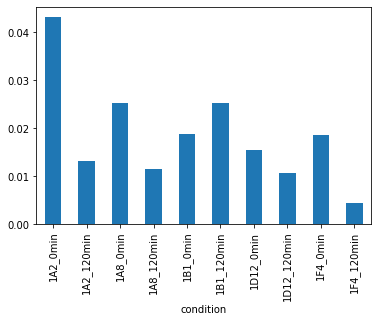

In [18]:
(data_uncorr.groupby('condition')['distance'].mean()/data.groupby('condition')['distance'].mean() - 1).plot(kind="bar")
plt.savefig("zerror_40nm_effect_on_average_distance.pdf", bbox_inches='tight')

In [ ]:
resampled = pd.DataFrame()
df = df.drop_duplicates()
for _, sub in df.groupby("uniqueid"):
    tmp = sub.iloc[::3].copy()
    tmp.frame = tmp.frame.values // 3
    resampled = pd.concat([resampled, tmp])
resampled.drop_duplicates().to_csv(f"{basedir}/{today}_{outname}.resampled_30s.zip", index=False, compression="zip")

In [ ]:
import seaborn as sns
df['condition'] = df['date']
sub = df[(df['cell_line'] == "1A2") & (df['induction_time'] == "0min")]
sub.head()

In [ ]:
sns.ecdfplot(sub, x="distance", hue="condition")